In [1]:
# Импорты и настройки
import numpy as np
import json
import time
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


In [ ]:
SAVE_FIGURES = True
OUTPUT_PLT_PATH = f'./tests/schedule_sim_results.png'

In [ ]:
# Укажите имя файла с расписанием
FILENAME = f"./tests/best_schedule.json"

In [5]:
# Загрузка параметров системы из нового формата JSON

def load_system_parameters(filename=FILENAME):
    """Загрузить параметры системы из JSON файла нового формата"""
    with open(filename, encoding="utf-8") as f:
        data = json.load(f)

    # Парсим время работы
    work_hours_str = data["parameters"]["work_hours"]
    start_str, end_str = work_hours_str.split(" - ")
    WORK_START_HOUR = int(start_str.split(":")[0])
    WORK_END_HOUR = int(end_str.split(":")[0])
    WORK_HOURS = WORK_END_HOUR - WORK_START_HOUR
    
    # Количество касс
    NUM_SIMPLE_REGISTERS = data["parameters"]["num_simple_registers"]
    NUM_AUTO_REGISTERS = data["parameters"]["num_auto_registers"]
    
    # Среднее время обслуживания (используем значения по умолчанию или из данных)
    AUTO_REGISTER_SERVICE_TIME = data["parameters"]["auto_service_time"]

    # Поток клиентов
    CLIENT_FLOW = data["parameters"]["client_flow"]
    
    # Преобразуем информацию о кассирах
    CASHIERS = []
    for cashier_key in sorted(data["cashier_shifts"].keys()):
        cashier_id = int(cashier_key.split("_")[1])
        CASHIERS.append({
            'id': cashier_id,
            'simple_time': data["cashier_prod"][str(cashier_id)]["simple_time"],
            'auto_time': data["cashier_prod"][str(cashier_id)]["auto_time"]
        })
    
    # Создаем словарь для быстрого поиска кассира по ID
    CASHIER_BY_ID = {cashier['id']: cashier for cashier in CASHIERS}
    
    # Преобразуем расписание из разделенного формата в единый массив
    simple_schedule = data["schedule"]["simple_registers"]
    auto_schedule = data["schedule"]["auto_registers"]
    # Объединяем расписания
    schedule = []
    for hour_idx in range(WORK_HOURS):
        hour_schedule = []
        # Добавляем простые кассы
        for reg_idx in range(NUM_SIMPLE_REGISTERS):
            hour_schedule.append(simple_schedule[reg_idx][hour_idx])
        # Добавляем автоматические кассы
        for reg_idx in range(NUM_AUTO_REGISTERS):
            hour_schedule.append(auto_schedule[reg_idx][hour_idx])
        schedule.append(hour_schedule)
    
    

    return (WORK_START_HOUR, WORK_END_HOUR, WORK_HOURS, 
            NUM_SIMPLE_REGISTERS, NUM_AUTO_REGISTERS, 
            AUTO_REGISTER_SERVICE_TIME, CLIENT_FLOW, CASHIERS, CASHIER_BY_ID, schedule)

# Загружаем параметры
(WORK_START_HOUR, WORK_END_HOUR, WORK_HOURS, 
 NUM_SIMPLE_REGISTERS, NUM_AUTO_REGISTERS, 
 AUTO_REGISTER_SERVICE_TIME, CLIENT_FLOW, CASHIERS, CASHIER_BY_ID, schedule) = load_system_parameters()

print(f"Параметры системы загружены из {FILENAME}")
print(f"Время работы: {WORK_START_HOUR}:00 - {WORK_END_HOUR}:00")
print(f"Простых касс: {NUM_SIMPLE_REGISTERS}, Автоматических: {NUM_AUTO_REGISTERS}")
print(f"Кассиров: {len(CASHIERS)}")
print(f"Время обслуживания автоматических касс: {AUTO_REGISTER_SERVICE_TIME} сек")


Параметры системы загружены из Tests/4/best_schedule.json
Время работы: 6:00 - 23:00
Простых касс: 4, Автоматических: 3
Кассиров: 4
Время обслуживания автоматических касс: 150 сек


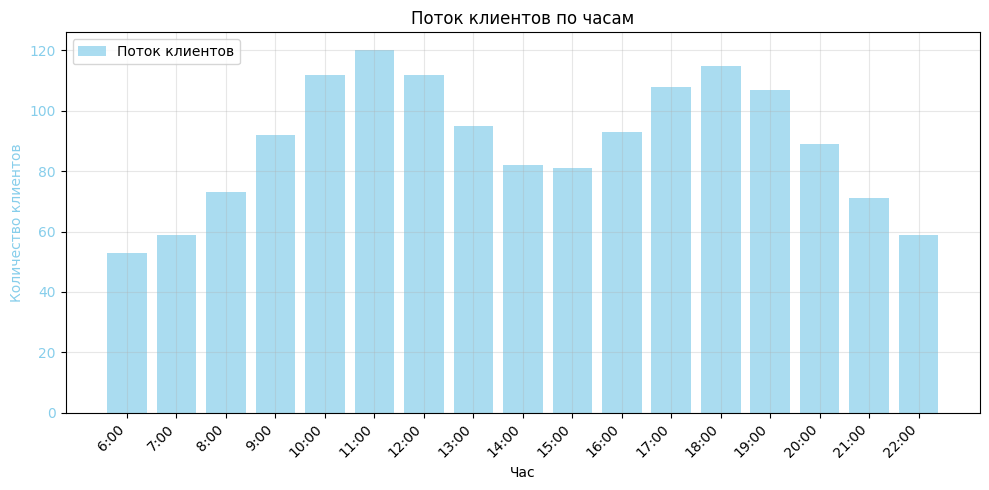

In [6]:
# Визуализация потока клиентов
hours_labels = [f"{WORK_START_HOUR + h}:00" for h in range(WORK_HOURS)]

plt.figure(figsize=(10, 5))
plt.bar(range(len(CLIENT_FLOW)), CLIENT_FLOW, alpha=0.7, color='skyblue', label='Поток клиентов')
plt.xlabel('Час')
plt.ylabel('Количество клиентов', color='skyblue')
plt.tick_params(axis='y', labelcolor='skyblue')
plt.xticks(range(WORK_HOURS), hours_labels, rotation=45, ha='right')
plt.title('Поток клиентов по часам')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [7]:
SECONDS_PER_STEP = 1
SIMULATION_SPEED = 1000

In [8]:
# Настройки симуляции
SIMULATION_START_HOUR = 0  # Начинаем с первого часа работы

print(f"Симуляция начнется с часа: {WORK_START_HOUR + SIMULATION_START_HOUR}:00")


Симуляция начнется с часа: 6:00


In [9]:
# Класс для представления кассы
class Register:
    def __init__(self, register_id, is_auto, default_service_time):
        self.id = register_id
        self.is_auto = is_auto
        self.default_service_time = default_service_time
        self.queue = deque()
        self.current_client = None
        self.time_left = 0
        self.cashier = None
        self.total_clients_served = 0
        
        # Статистика по времени обслуживания
        self.service_times = []  # Время обслуживания каждого клиента
        self.wait_times = []     # Время ожидания каждого клиента
        self.total_times = []    # Общее время в системе
        
    def get_service_time(self):
        """Получить время обслуживания в зависимости от наличия кассира"""
        if self.cashier is not None:
            return self.cashier['auto_time'] if self.is_auto else self.cashier['simple_time']
        elif self.is_auto:
            return self.default_service_time
        else:
            return None
    
    def is_working(self):
        """Проверка работает ли касса"""
        return self.cashier is not None or self.is_auto
    
    def add_client(self, arrival_time):
        """Добавить клиента в очередь"""
        self.queue.append({'arrival': arrival_time, 'wait_start': arrival_time})
    
    def update(self, current_time):
        """Обновить состояние кассы"""
        if not self.is_working():
            return None
        
        completed_client = None
        
        # Если обслуживается клиент
        if self.current_client is not None:
            self.time_left -= 1
            if self.time_left <= 0:
                completed_client = self.current_client
                completed_client['service_end'] = current_time
                completed_client['total_time'] = current_time - completed_client['arrival']
                completed_client['wait_time'] = completed_client['service_start'] - completed_client['arrival']
                completed_client['service_time'] = completed_client['service_end'] - completed_client['service_start']
                
                # Сохраняем статистику
                self.service_times.append(completed_client['service_time'])
                self.wait_times.append(completed_client['wait_time'])
                self.total_times.append(completed_client['total_time'])
                
                self.current_client = None
                self.total_clients_served += 1
        
        # Взять следующего клиента из очереди
        if self.current_client is None and len(self.queue) > 0:
            service_time = self.get_service_time()
            if service_time is not None:
                self.current_client = self.queue.popleft()
                self.current_client['service_start'] = current_time
                self.time_left = service_time
        
        return completed_client
    
    def get_average_service_time(self):
        """Получить среднее время обслуживания в секундах"""
        return np.mean(self.service_times) if self.service_times else 0
    
    def get_average_wait_time(self):
        """Получить среднее время ожидания в секундах"""
        return np.mean(self.wait_times) if self.wait_times else 0
    
    def get_average_total_time(self):
        """Получить среднее общее время в системе в секундах"""
        return np.mean(self.total_times) if self.total_times else 0


In [10]:
# Класс симулятора
class CashierSimulator:
    def __init__(self, num_simple, num_auto, auto_service_time, client_flow, work_hours):
        self.num_simple = num_simple
        self.num_auto = num_auto
        self.auto_service_time = auto_service_time
        self.client_flow = client_flow
        self.work_hours = work_hours
        self.registers = []
        self.completed_clients = []
        
        # Почасовая статистика
        self.hourly_stats = []
        for hour in range(work_hours):
            self.hourly_stats.append({
                'hour': hour,
                'clients_arrived': 0,
                'clients_served': 0,
                'total_service_time': 0,
                'total_wait_time': 0,
                'total_time': 0,
                'avg_service_time': 0,
                'avg_wait_time': 0,
                'avg_total_time': 0
            })
        
        # Создаём кассы
        for i in range(num_simple):
            self.registers.append(Register(i, False, None))
        for i in range(num_auto):
            self.registers.append(Register(num_simple + i, True, auto_service_time))
    
    def find_shortest_queue(self):
        """Найти кассу с самой короткой очередью среди работающих"""
        working_registers = [r for r in self.registers if r.is_working()]
        if not working_registers:
            return None
        return min(working_registers, key=lambda r: len(r.queue) + (1 if r.current_client else 0))
    
    def update_hourly_stats(self, completed_client):
        """Обновить почасовую статистику"""
        arrival_hour = completed_client['arrival'] // 3600
        
        if 0 <= arrival_hour < len(self.hourly_stats):
            stats = self.hourly_stats[arrival_hour]
            stats['total_wait_time'] += completed_client['wait_time']
            stats['total_service_time'] += completed_client['service_time']
            stats['total_time'] += completed_client['total_time']
            stats['clients_served'] += 1
            
            if stats['clients_served'] > 0:
                stats['avg_wait_time'] = stats['total_wait_time'] / stats['clients_served']
                stats['avg_service_time'] = stats['total_service_time'] / stats['clients_served']
                stats['avg_total_time'] = stats['total_time'] / stats['clients_served']
    
    def get_hourly_statistics(self):
        """Получить почасовую статистику"""
        return self.hourly_stats


In [11]:
# Визуализация очередей с tqdm-bars
class TqdmQueueVisualizer:
    def __init__(self, schedule, start_hour=0):
        self.schedule = schedule
        self.simulator = CashierSimulator(
            NUM_SIMPLE_REGISTERS, NUM_AUTO_REGISTERS, AUTO_REGISTER_SERVICE_TIME,
            CLIENT_FLOW, WORK_HOURS
        )
        self.current_hour = start_hour
        self.current_second = 0
        self.speed = SECONDS_PER_STEP
        
        # Инициализация симулятора
        for reg in self.simulator.registers:
            reg.queue.clear()
            reg.current_client = None
            reg.time_left = 0
            reg.cashier = None
        
        self.queue_history = []
        self.served_history = []
        self.hourly_served = []
        
        # Генерация клиентов
        self.client_idx = 0
        self.current_hour_clients = []
        self.current_hour_served = 0
        self.generate_hour_clients()
        
        # tqdm бары
        self.register_bars = []
        self.setup_tqdm_bars()
    
    def generate_hour_clients(self):
        """Генерировать клиентов для текущего часа"""
        if self.current_hour < WORK_HOURS:
            num_clients = CLIENT_FLOW[self.current_hour]
            arrivals = sorted(np.random.uniform(0, 3600, num_clients))
            self.current_hour_clients = []
            for arrival in arrivals:
                self.current_hour_clients.append({
                    'hour': self.current_hour, 'second': int(arrival),
                    'global_time': self.current_hour * 3600 + int(arrival)
                })
            self.client_idx = 0
            
            # Обновляем статистику прибывших клиентов
            if self.current_hour < len(self.simulator.hourly_stats):
                self.simulator.hourly_stats[self.current_hour]['clients_arrived'] = num_clients
    
    def setup_tqdm_bars(self):
        """Настройка tqdm баров"""
        self.time_bar = tqdm(
            total=WORK_HOURS * 3600,
            desc="Время в симуляции",
            bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}{postfix}',
            position=0, leave=True
        )
        
        self.register_bars = []
        for i, reg in enumerate(self.simulator.registers):
            bar = tqdm(
                total=50,
                desc=f"Касса {i+1} {'(A)' if reg.is_auto else '(S)'}",
                bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}{postfix}',
                position=i+1, leave=True
            )
            self.register_bars.append(bar)
    
    def update_tqdm_bars(self):
        """Обновление всех tqdm баров"""
        current_global_seconds = self.current_hour * 3600 + self.current_second
        self.time_bar.n = current_global_seconds
        
        current_hour_display = WORK_START_HOUR + self.current_hour
        current_minute = self.current_second // 60
        current_second_display = self.current_second % 60
        
        progress_percent = (current_global_seconds / (WORK_HOURS * 3600)) * 100
        time_str = f"{current_hour_display:02d}:{current_minute:02d}:{current_second_display:02d}"
        self.time_bar.set_postfix_str(f"{time_str} ({progress_percent:.1f}%)")
        self.time_bar.refresh()
        
        for i, (reg, bar) in enumerate(zip(self.simulator.registers, self.register_bars)):
            if not reg.is_working():
                bar.n = 0
                bar.set_postfix_str("Не работает")
            elif reg.current_client is not None:
                bar.n = 1 + len(reg.queue)
                time_left = reg.time_left
                cashier_name = f"K{reg.cashier['id']}" if reg.cashier else "Авто"
                status = f"{cashier_name} ({time_left}с) : {len(reg.queue) + 1}"
                bar.set_postfix_str(status)
            elif len(reg.queue) > 0:
                bar.n = len(reg.queue)
                cashier_name = f"K{reg.cashier['id']}" if reg.cashier else "Авто"
                bar.set_postfix_str(f"{cashier_name}: {len(reg.queue)}")
            else:
                bar.n = 0
                cashier_name = f"K{reg.cashier['id']}" if reg.cashier else "Авто"
                bar.set_postfix_str(f"{cashier_name}: {len(reg.queue)}")
            
            bar.refresh()
    
    def redistribute_clients_from_closed_registers(self):
        """Перераспределить клиентов из закрывающихся касс"""
        total_redistributed = 0
        closed_registers = []
        
        for reg in self.simulator.registers:
            if not reg.is_working() and len(reg.queue) > 0:
                clients_count = len(reg.queue)
                clients_to_redistribute = list(reg.queue)
                reg.queue.clear()
                
                closed_registers.append((reg.id, clients_count))
                
                for client in clients_to_redistribute:
                    target_register = self.simulator.find_shortest_queue()
                    if target_register:
                        target_register.queue.append(client)
                        total_redistributed += 1
        
        if total_redistributed > 0:
            current_hour_display = WORK_START_HOUR + self.current_hour
            print(f"\n{current_hour_display:02d}:00 - Перераспределено {total_redistributed} клиентов:")
            for reg_id, count in closed_registers:
                reg_type = "A" if reg_id >= NUM_SIMPLE_REGISTERS else "S"
                print(f"   • Касса {reg_id+1} ({reg_type}) закрыта: {count} клиентов перераспределены")
    
    def step(self):
        """Один шаг симуляции"""
        if self.current_hour >= WORK_HOURS:
            return False
        
        # Назначаем кассиров на текущий час
        if self.current_second == 0:
            current_hour_display = WORK_START_HOUR + self.current_hour
            
            for reg_id, cashier_id in enumerate(self.schedule[self.current_hour]):
                if cashier_id is not None and cashier_id in CASHIER_BY_ID:
                    self.simulator.registers[reg_id].cashier = CASHIER_BY_ID[cashier_id]
                else:
                    self.simulator.registers[reg_id].cashier = None
            
            self.redistribute_clients_from_closed_registers()
            self.generate_hour_clients()
        
        # Обрабатываем секунды
        for _ in range(self.speed):
            if self.current_hour >= WORK_HOURS:
                break
                
            current_global_time = self.current_hour * 3600 + self.current_second
            
            # Добавляем прибывших клиентов
            while (self.client_idx < len(self.current_hour_clients) and 
                   self.current_hour_clients[self.client_idx]['global_time'] <= current_global_time):
                register = self.simulator.find_shortest_queue()
                if register:
                    register.add_client(current_global_time)
                self.client_idx += 1
            
            # Обновляем кассы
            for reg in self.simulator.registers:
                completed = reg.update(current_global_time)
                if completed:
                    self.simulator.completed_clients.append(completed)
                    self.current_hour_served += 1
                    self.simulator.update_hourly_stats(completed)
            
            self.current_second += 1
            if self.current_second >= 3600:
                self.hourly_served.append(self.current_hour_served)
                self.current_hour_served = 0
                self.current_second = 0
                self.current_hour += 1
        
        self.update_tqdm_bars()
        
        # Сохраняем статистику
        total_queue = sum(len(r.queue) for r in self.simulator.registers)
        self.queue_history.append(total_queue)
        self.served_history.append(len(self.simulator.completed_clients))
        
        return True
    
    def get_current_state(self):
        """Получить текущее состояние для отображения"""
        state = {
            'hour': self.current_hour, 'minute': self.current_second // 60,
            'registers': [], 'total_queue': 0,
            'total_served': len(self.simulator.completed_clients),
            'queue_history': self.queue_history.copy(),
            'served_history': self.served_history.copy()
        }
        
        for reg in self.simulator.registers:
            state['registers'].append({
                'id': reg.id, 'is_auto': reg.is_auto, 'queue_length': len(reg.queue),
                'has_client': reg.current_client is not None,
                'cashier': reg.cashier['id'] if reg.cashier else None,
                'is_working': reg.is_working()
            })
            state['total_queue'] += len(reg.queue)
        
        return state
    
    def get_hourly_statistics(self):
        """Получить почасовую статистику времени обслуживания"""
        return self.simulator.get_hourly_statistics()
    
    def cleanup(self):
        """Очистка tqdm баров"""
        self.time_bar.close()
        for bar in self.register_bars:
            bar.close()
    
    def get_overall_statistics(self):
        """Получить общую статистику по всем кассам"""
        total_service_times = []
        total_wait_times = []
        total_times = []
        
        for reg in self.simulator.registers:
            total_service_times.extend(reg.service_times)
            total_wait_times.extend(reg.wait_times)
            total_times.extend(reg.total_times)
        
        return {
            'total_clients_served': len(self.simulator.completed_clients),
            'avg_service_time': np.mean(total_service_times) if total_service_times else 0,
            'avg_wait_time': np.mean(total_wait_times) if total_wait_times else 0,
            'avg_total_time': np.mean(total_times) if total_times else 0,
            'service_times': total_service_times,
            'wait_times': total_wait_times,
            'total_times': total_times
        }


In [12]:
# Основная функция визуализации
def visualize_queues_tqdm(schedule, start_hour=None):
    """Запустить визуализацию очередей с tqdm-bars"""
    if start_hour is None:
        start_hour = SIMULATION_START_HOUR
    
    print(" Запуск визуализации очередей с tqdm-bars ")
    print("=" * 60)
    print(f"С  : {WORK_START_HOUR + start_hour}:00")
    print(f"ДО : {WORK_START_HOUR + WORK_HOURS - 1}:00")
    print("=" * 60)
    
    viz = TqdmQueueVisualizer(schedule, start_hour)

    try:
        # Запускаем симуляцию
        while viz.step():
            time.sleep(1/SIMULATION_SPEED)

    except KeyboardInterrupt:
        print("\nСимуляция остановлена пользователем")
        
        # Очищаем tqdm бары
        viz.cleanup()
    
    # Возвращаем статистику
    return viz.get_hourly_statistics(), viz.get_overall_statistics()


In [13]:
# Запускаем визуализацию очередей
# Можно изменить start_hour, чтобы начать симуляцию с определенного часа
# Например: visualize_queues_tqdm(schedule, start_hour=10)
hourly_stats, overall_stats = visualize_queues_tqdm(schedule)


 Запуск визуализации очередей с tqdm-bars 
С  : 6:00
ДО : 22:00


Время в симуляции:   0%|          | 0/61200

Касса 1 (S):   0%|          | 0/50

Касса 2 (S):   0%|          | 0/50

Касса 3 (S):   0%|          | 0/50

Касса 4 (S):   0%|          | 0/50

Касса 5 (A):   0%|          | 0/50

Касса 6 (A):   0%|          | 0/50

Касса 7 (A):   0%|          | 0/50


21:00 - Перераспределено 1 клиентов:
   • Касса 1 (S) закрыта: 1 клиентов перераспределены


In [14]:
# Анализ и визуализация статистики времени обслуживания клиентов
print("\n" + "="*60)
print("СТАТИСТИКА ВРЕМЕНИ ОБСЛУЖИВАНИЯ КЛИЕНТОВ")
print("="*60)

# Общая статистика
print(f"\nОбщая статистика:")
print(f"Всего обслужено клиентов: {overall_stats['total_clients_served']}")
print(f"Среднее время обслуживания: {overall_stats['avg_service_time']:.1f} сек ({overall_stats['avg_service_time']/60:.1f} мин)")
print(f"Среднее время ожидания: {overall_stats['avg_wait_time']:.1f} сек ({overall_stats['avg_wait_time']/60:.1f} мин)")
print(f"Среднее общее время в системе: {overall_stats['avg_total_time']:.1f} сек ({overall_stats['avg_total_time']/60:.1f} мин)")

# Почасовая статистика
print(f"\nПочасовая статистика:")
print(f"{'Час':<8} {'Прибыло':<8} {'Обслужено':<10} {'Ср.обслуж.':<12} {'Ср.ожидание':<12}")
print("-" * 70)

for stats in hourly_stats:
    hour_str = f"{WORK_START_HOUR + stats['hour']:02d}:00"
    avg_service_min = stats['avg_service_time'] / 60
    avg_wait_min = stats['avg_wait_time'] / 60
    
    print(f"{hour_str:<8} {stats['clients_arrived']:<8} {stats['clients_served']:<10} "
          f"{avg_service_min:<12.1f} {avg_wait_min:<12.1f}")


СТАТИСТИКА ВРЕМЕНИ ОБСЛУЖИВАНИЯ КЛИЕНТОВ

Общая статистика:
Всего обслужено клиентов: 1516
Среднее время обслуживания: 121.8 сек (2.0 мин)
Среднее время ожидания: 34.4 сек (0.6 мин)
Среднее общее время в системе: 156.2 сек (2.6 мин)

Почасовая статистика:
Час      Прибыло  Обслужено  Ср.обслуж.   Ср.ожидание 
----------------------------------------------------------------------
06:00    53       53         2.5          0.5         
07:00    59       59         1.9          0.4         
08:00    73       73         5.3          0.3         
09:00    92       92         1.3          0.3         
10:00    112      112        1.3          0.9         
11:00    120      120        1.3          0.6         
12:00    112      112        1.3          0.7         
13:00    95       95         1.7          0.4         
14:00    82       82         2.1          0.4         
15:00    81       81         2.0          0.4         
16:00    93       93         1.9          0.6         
17:00    108

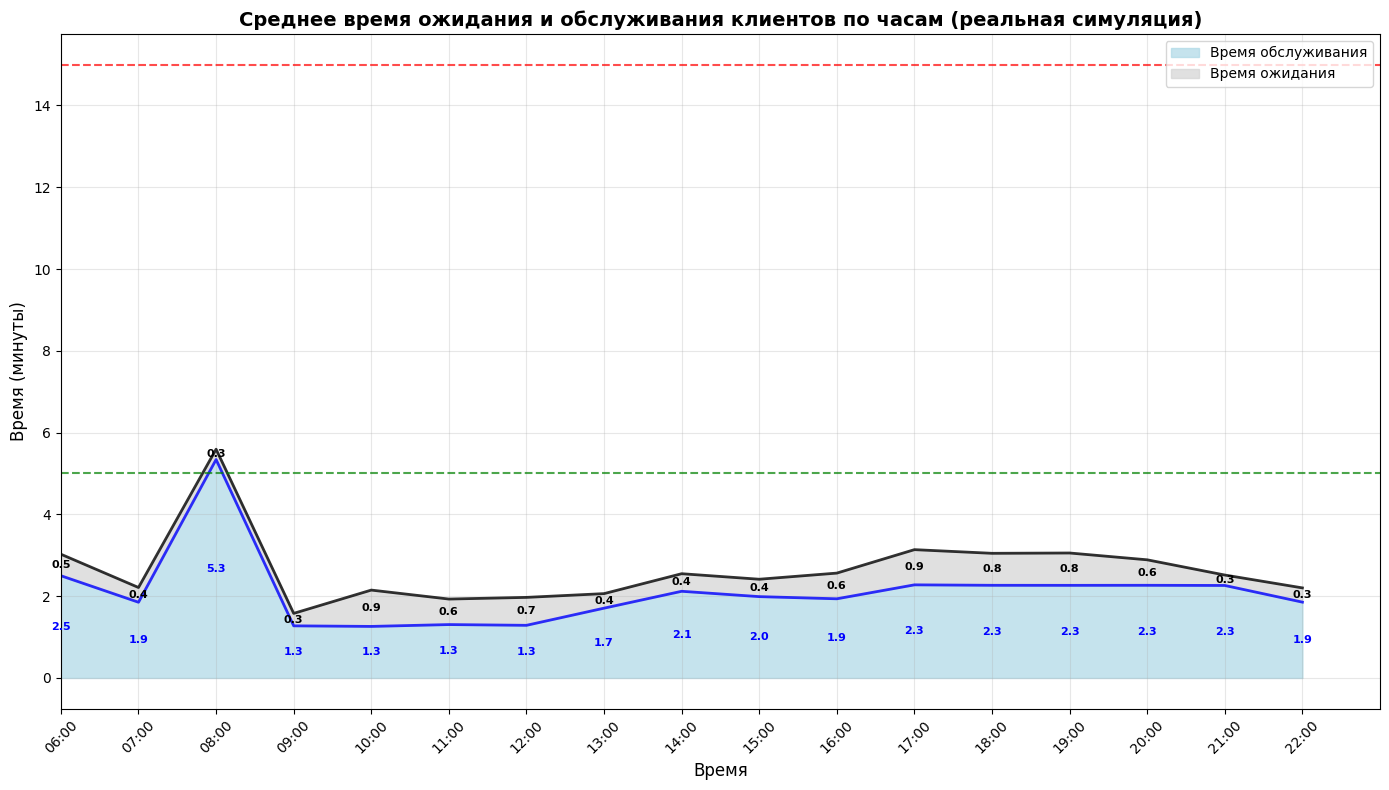

In [15]:
# Создаем график аналогичный графику 3 из CassaScheduler_info.ipynb
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Подготавливаем данные для графика
hours_labels = [f"{WORK_START_HOUR + h:02d}:00" for h in range(WORK_HOURS)]
service_times_min = [stats['avg_service_time'] / 60 for stats in hourly_stats]
wait_times_min = [stats['avg_wait_time'] / 60 for stats in hourly_stats]
total_times_min = [stats['avg_total_time'] / 60 for stats in hourly_stats]

# Создаем накопительный график с заливкой
# Заливка для времени обслуживания (снизу)
ax.fill_between(range(WORK_HOURS), 0, service_times_min, 
                alpha=0.7, color='lightblue', label='Время обслуживания')

# Заливка для времени ожидания (сверху)
ax.fill_between(range(WORK_HOURS), service_times_min, total_times_min, 
                alpha=0.7, color='lightgray', label='Время ожидания')

# Линии для границ
ax.plot(range(WORK_HOURS), service_times_min, 'b-', linewidth=2, alpha=0.8)
ax.plot(range(WORK_HOURS), total_times_min, 'k-', linewidth=2, alpha=0.8)

# Добавляем значения на график
for i, (wait, service, total) in enumerate(zip(wait_times_min, service_times_min, total_times_min)):
    if total > 0:
        ax.text(i, service + (total - service)/2, f'{total - service:.1f}', 
                ha='center', va='center', fontsize=8, color='black', fontweight='bold', zorder=10)
        ax.text(i, service/2, f'{service:.1f}',
                ha='center', va='center', fontsize=8, color='blue', fontweight='bold', zorder=10)

ax.set_xlabel('Время', fontsize=12)
ax.set_ylabel('Время (минуты)', fontsize=12)
ax.set_title('Среднее время ожидания и обслуживания клиентов по часам (реальная симуляция)', fontsize=14, fontweight='bold')
ax.set_xticks(range(WORK_HOURS))
ax.set_xticklabels(hours_labels, rotation=45)
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, WORK_HOURS)

# Добавляем горизонтальные линии для сравнения
ax.axhline(y=15, color='red', linestyle='--', alpha=0.7, 
            label='Допустимое время ожидания (15м)')
ax.axhline(y=5, color='green', linestyle='--', alpha=0.7, 
            label='Целевое время ожидания (5м)')

plt.tight_layout()
if SAVE_FIGURES: plt.savefig(OUTPUT_PLT_PATH, dpi=150, bbox_inches='tight')
plt.show()
